In [119]:
import pandas as pd
import math
import scipy
import librosa
import numpy as np
import librosa.display
import librosa.decompose
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Audio
from sklearn.decomposition import FastICA, PCA

# general laod example


In [318]:
def loadasom(n):
    d = {}

    


    pn = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\6dB\pump\id_04\normal\000000' + str(n) + '.wav'
    pa = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\6dB\pump\id_04\abnormal\000000' + str(n) + '.wav'   
    d['pump'] = {'n': librosa.load(pn, sr=None, mono=False),
             'a': librosa.load(pa, sr=None, mono=False)}
    pn = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\6dB\fan\id_04\normal\000000' + str(n) + '.wav' 
    pa = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\6dB\fan\id_04\abnormal\000000' + str(n) + '.wav'     
    d['fan'] = {'n': librosa.load(pn, sr=None, mono=False),
             'a': librosa.load(pa, sr=None, mono=False)}
    pn = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\6dB\slider\id_02\normal\000000' + str(n) + '.wav' 
    pa = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\6dB\slider\id_02\abnormal\000000' + str(n) + '.wav'    
    d['slider'] = {'n': librosa.load(pn, sr=None, mono=False),
             'a': librosa.load(pa, sr=None, mono=False)}
    pn = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\6dB\valve\id_06\normal\000000' + str(n) + '.wav' 
    pa = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\6dB\valve\id_06\abnormal\000000' + str(n) + '.wav'     
    d['valve'] = {'n': librosa.load(pn, sr=None, mono=False),
             'a': librosa.load(pa, sr=None, mono=False)}

    sr = d['pump']['n'][1]
    t = np.linspace(0,len(d['pump']['n'][0][0])/sr,len(d['pump']['n'][0][0]))
    return d,t,sr
d,t,sr = loadasom(12)

# Varibility

## SNR

In [228]:
def snr_estimation_all(s):
    return np.mean(s) / np.std(s)


snr = pd.DataFrame()

for m in d:
    for an in d[m]:
        for ic,c in enumerate(d[m][an][0]):
            snr.at[f'{m}_{an}',str(ic)+'_all'] =  round(snr_estimation_all(c)*10000,2)

snr['s_m'] = snr.mean(axis = 1) 
snr['s_s'] = snr.drop('s_m', axis=1).std(axis = 1) 
snr
# todo try to combine in dominate channel     

,0_all,1_all,2_all,3_all,4_all,5_all,6_all,7_all,s_m,s_s
pump_n,1.63,1.09,1.27,1.75,1.07,0.82,1.27,2.27,1.39625,0.464049
pump_a,0.44,0.22,0.17,0.41,0.57,1.01,0.81,0.38,0.50125,0.286478
fan_n,-7.95,-7.69,-8.48,-7.47,-7.15,-7.28,-7.08,-7.58,-7.58500,0.462262
fan_a,0.93,1.32,0.88,1.41,1.11,0.55,1.16,0.96,1.04000,0.272239
slider_n,2.41,2.32,2.35,2.01,2.18,2.56,2.28,2.32,2.30375,0.161151
slider_a,0.62,0.27,-0.03,0.12,0.29,0.42,0.13,0.76,0.32250,0.266069
valve_n,1.13,2.94,3.31,3.11,4.21,5.14,2.74,3.43,3.25125,1.158810
valve_a,-1.39,-4.27,-0.36,1.82,0.68,0.86,2.03,-2.00,-0.32875,2.140270


In [226]:
snr

,0_all,1_all,2_all,3_all,4_all,5_all,6_all,7_all,s_m,s_s
pump_n,-0.75,-0.95,-0.65,-0.62,-1.00,-1.28,-1.14,-0.80,-0.89875,0.235399
pump_a,-0.70,-0.66,-0.30,-0.59,-0.89,-0.97,-0.99,-0.89,-0.74875,0.234182
fan_n,-1.16,-0.06,-0.58,-0.45,-0.68,-0.17,1.05,-0.90,-0.36875,0.676555
fan_a,0.17,0.09,0.10,0.32,0.09,0.06,0.23,0.22,0.16000,0.090711
slider_n,-3.90,-3.68,-3.66,-3.68,-3.66,-3.71,-4.10,-3.95,-3.79250,0.168247
slider_a,-4.38,-4.53,-5.09,-4.91,-4.40,-4.28,-3.87,-4.00,-4.43250,0.414100
valve_n,0.10,-3.84,-1.10,-2.73,-3.26,-1.17,-1.10,-2.00,-1.88750,1.316041
valve_a,-3.85,0.61,-2.63,0.57,-4.46,-1.96,0.66,-0.67,-1.46625,2.065187


160000 16000
0


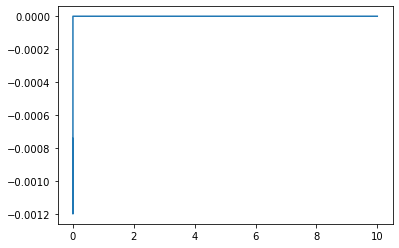

In [93]:
# To slow ... TODO check better way bigger windows matrix operation
def snr_estimation_window(s,k=None):
    pnts = len(s)
    snr = np.zeros(pnts)
    if not k:
        k = int(pnts*.10)  
    print(pnts,k)
    for i in range(0,pnts//k):
        if i%k==0:
            print(i)
        # time boundaries
        bndL = np.max((0,i-k))
        bndU = np.min((pnts,i+k))
    
        # extract parts of signals
        sigpart = s[range(bndL,bndU)]

        # compute windowed SNR
        snr[i] = np.mean(sigpart) / np.std(sigpart)

    return snr

sn= d['pump']['n'][0][0]
sa = d['pump']['a'][0][0]
#plt.plot(t,sn)
#plt.plot(t,sa)

plt.plot(t[0:],snr_estimation_window(sn[0:]))

## PSNR 
https://dsp.stackexchange.com/questions/38065/peak-signal-to-noise-ratio-psnr-in-python-for-an-image

## CV

In [232]:
def cv_estimation_all(s):
    return np.std(s)/np.mean(s)


cv = pd.DataFrame()

for m in d:
    for an in d[m]:
        for ic,c in enumerate(d[m][an][0]):
            cv.at[f'{m}_{an}',str(ic)+'_v'] =  round(cv_estimation_all(c))
cv['v_m'] = cv.mean(axis = 1) 
cv['v_s'] = cv.drop('v_m', axis=1).std(axis = 1) 
cv

,0_v,1_v,2_v,3_v,4_v,5_v,6_v,7_v,v_m,v_s
pump_n,-13246.0,-10502.0,-15425.0,-16259.0,-10043.0,-7827.0,-8784.0,-12556.0,-11830.250,3055.002350
pump_a,-14334.0,-15072.0,-33501.0,-17046.0,-11270.0,-10337.0,-10149.0,-11188.0,-15362.125,7742.210785
fan_n,-8639.0,-158634.0,-17104.0,-22101.0,-14773.0,-58186.0,9546.0,-11101.0,-35124.000,53410.842570
fan_a,59677.0,109535.0,98867.0,30892.0,110883.0,178392.0,43122.0,44495.0,84482.875,49493.820427
slider_n,-2566.0,-2717.0,-2731.0,-2714.0,-2734.0,-2694.0,-2440.0,-2529.0,-2640.625,112.904432
slider_a,-2283.0,-2210.0,-1963.0,-2037.0,-2274.0,-2337.0,-2586.0,-2502.0,-2274.000,210.565226
valve_n,97483.0,-2601.0,-9053.0,-3657.0,-3069.0,-8569.0,-9100.0,-4989.0,7055.625,36639.796549
valve_a,-2600.0,16261.0,-3804.0,17613.0,-2244.0,-5102.0,15213.0,-14961.0,2547.000,12132.032358


In [230]:
cv

,0_v,1_v,2_v,3_v,4_v,5_v,6_v,7_v,v_m,v_s
pump_n,6147.0,9144.0,7893.0,5715.0,9334.0,12189.0,7903.0,4404.0,7841.125,2450.684769
pump_a,22585.0,44949.0,58393.0,24181.0,17620.0,9944.0,12356.0,26447.0,27059.375,16599.233691
fan_n,-1258.0,-1301.0,-1179.0,-1338.0,-1399.0,-1374.0,-1413.0,-1319.0,-1322.625,77.608795
fan_a,10801.0,7562.0,11339.0,7085.0,8986.0,18186.0,8593.0,10403.0,10369.375,3504.383742
slider_n,4143.0,4301.0,4263.0,4977.0,4584.0,3900.0,4378.0,4302.0,4356.000,317.581036
slider_a,16003.0,36775.0,-351846.0,86687.0,34354.0,23949.0,77821.0,13102.0,-7894.375,141624.096733
valve_n,8831.0,3399.0,3022.0,3220.0,2375.0,1946.0,3645.0,2916.0,3669.250,2156.389294
valve_a,-7206.0,-2343.0,-27704.0,5480.0,14753.0,11694.0,4914.0,-5012.0,-678.000,13389.488489


# multi channel ICA and PCA based

## ICA channel select and mix with

In [237]:
def ICA_2(sx):
    ica = FastICA(n_components=2, random_state=0, max_iter=50,fun='logcosh',tol=0.000005)
    isas = ica.fit_transform(sx.T)
    mix_matrix = ica.mixing_
    return isas,mix_matrix

def ICA_2_main_channel(mix_matrix):
    # returns dominat ica channel with the most mixing varaiton
    # and the dominate input channel mis that is directed to the device
    r = np.array([0.,0.])
    r[0] = np.abs(np.max(mix_matrix[:,0])- np.min(mix_matrix[:,0]))
    r[1] = np.abs(np.max(mix_matrix[:,1])- np.min(mix_matrix[:,1]))
    #print(mix_matrix[:,1])
    ica_range = np.max(r)
    ica_chnr = np.argmax(r)
    in_chnr = int(np.where(mix_matrix[:,ica_chnr]==np.min(mix_matrix[:,ica_chnr]))[0])
    return ica_range, ica_chnr, in_chnr 
    

def ICA_2_HP(s):
    filtcut = 30
    filtb,filta = scipy.signal.butter(7,filtcut/(sr/2),btype='high')
    fdata = scipy.signal.filtfilt(filtb,filta,s)
    return fdata

sn= ICA_2_HP(d['pump']['n'][0] ) 
s,a = ICA_2(sn) 
ic_range, ic,mic = ICA_2_main_channel(a)
print(ic_range, ic,mic, a[:,ic] )

# check on mix matrix 
mm = pd.DataFrame()

for m in d:
    for an in d[m]:
        s,a = ICA_2(ICA_2_HP(d[m][an][0]) )
        ic_range, ic,mic = ICA_2_main_channel(a)
        mm.at[f'{m}_{an}','range'] =  ic_range
        mm.at[f'{m}_{an}','micnr'] =  mic
        for i in range(8):
            mm.at[f'{m}_{an}','c_'+str(i)] = a[i,ic] 
        
        
mm
# TODO mic picker is not as robust as hoped!!

3.8243483170004 1 6 [ 0.46380268  2.24172556  2.77889613  2.28391141  0.62232631 -0.67414168
 -1.04545219 -0.75758926]


,range,micnr,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7
pump_n,3.824348,6.0,0.463803,2.241726,2.778896,2.283911,0.622326,-0.674142,-1.045452,-0.757589
pump_a,6.766318,6.0,0.300459,3.152967,4.339095,3.562487,1.000936,-1.440572,-2.427223,-1.957418
fan_n,4.273319,0.0,-1.294366,-0.817540,0.793602,2.509795,2.978953,2.367374,0.613703,-0.823540
fan_a,2.829150,1.0,-1.753860,-1.786842,-0.803821,0.336370,1.042308,0.983667,-0.082802,-1.218347
slider_n,2.248151,6.0,-0.519434,0.335676,0.587821,0.356805,-0.490416,-1.314615,-1.660331,-1.401574
slider_a,5.679393,6.0,-1.075118,0.507927,1.561195,1.349586,0.277030,-2.717946,-4.118198,-3.550590
valve_n,3.027402,4.0,2.435990,1.746478,0.192539,-0.521802,-0.591412,-0.137573,0.969176,2.248856
valve_a,4.470397,3.0,2.348596,2.997720,1.948848,-1.472677,-0.992767,-1.271499,-0.968009,-1.202493


In [235]:
mm

,range,micnr,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7
pump_n,4.355465,6.0,-0.137841,1.841925,3.016912,3.012742,1.387893,-0.469179,-1.338553,-1.272446
pump_a,6.690008,6.0,0.118378,2.919741,4.142473,3.486003,0.747363,-1.744380,-2.547535,-2.023586
fan_n,3.291397,0.0,1.009553,1.418378,2.524088,3.833544,4.300951,4.035385,2.566314,1.409618
fan_a,5.818186,5.0,1.423370,2.026080,1.417578,-0.236938,-2.262470,-3.792106,-3.442601,-1.317116
slider_n,2.851700,6.0,0.475209,1.564073,1.644212,1.055674,-0.180325,-1.024226,-1.207488,-0.665392
slider_a,5.337254,6.0,-0.007276,1.350425,2.753721,2.556857,2.106012,-1.213311,-2.583533,-2.141396
valve_n,2.963976,0.0,-2.217978,-1.648848,-0.117195,0.649426,0.745999,0.268984,-0.821856,-2.077710
valve_a,3.224248,0.0,-2.128867,-1.477172,-0.203108,0.605961,1.095381,0.774309,-0.033926,-1.677781


## PCA componet energy sum

# FFT/PSD based

## peack detect

In [327]:
d,t,sr = loadasom('22')
def FFT_main_peacks(s,sr, k = 20):
    pnts = len(s)
    fcoef=scipy.fftpack.fft(s)
    hz = np.linspace(0,sr/2,num=math.floor(pnts/2.)+1)
    unscaled_amp = 2*np.abs(fcoef)[0:pnts//2+1] / len(fcoef) #np.abs(fcoef[0:pnts//2+1])
    peacks = scipy.signal.find_peaks(unscaled_amp,distance=sr//20)    
    peack_amp = unscaled_amp[peacks[0][0:k]]
    standard_scaled_amps = peack_amp/np.max(peack_amp)# (peack_amp - np.mean(peack_amp))*1./np.std(peack_amp)
                             
    #plt.plot(hz,unscaled_amp)
    #plt.plot(hz[peacks[0][0:k]],unscaled_amp[peacks[0][0:k]],'+')
    return hz[peacks[0][0:k]],standard_scaled_amps

fn,an = FFT_main_peacks(d['valve']['n'][0][0],sr)
fa,aa = FFT_main_peacks(d['valve']['a'][0][1],sr)
#plt.plot(fn,an)
#plt.plot(fa,aa)
#plt.show()
#plt.plot(fn,fa)

pl = np.stack((fn,an)).T
pl[pl[:,1].argsort()]
fp = pd.DataFrame()
for m in d:
    for an in d[m]:
        f,a = FFT_main_peacks(d[m][an][0][0],sr)
        pl = np.stack((f,a)).T
        pl[pl[:,1].argsort()]
        for i,f in enumerate(pl[:,0][:5]):
            #print(f)
            fp.at[f'{m}_{an}','f'+str(i)] = np.round(f)
            
fp

,f0,f1,f2,f3,f4
pump_n,66.0,179.0,300.0,431.0,575.0
pump_a,59.0,200.0,354.0,484.0,564.0
fan_n,47.0,154.0,236.0,377.0,473.0
fan_a,14.0,105.0,215.0,300.0,409.0
slider_n,22.0,166.0,248.0,390.0,496.0
slider_a,72.0,167.0,248.0,341.0,496.0
valve_n,31.0,159.0,245.0,334.0,478.0
valve_a,31.0,186.0,281.0,372.0,465.0


In [239]:
fp

,f0,f1,f2,f3,f4
pump_n,65.0,159.0,300.0,449.0,579.0
pump_a,72.0,168.0,274.0,355.0,451.0
fan_n,64.0,187.0,300.0,432.0,561.0
fan_a,40.0,121.0,216.0,296.0,394.0
slider_n,64.0,146.0,248.0,372.0,483.0
slider_a,22.0,139.0,248.0,328.0,435.0
valve_n,72.0,157.0,274.0,400.0,480.0
valve_a,72.0,155.0,274.0,418.0,548.0


In [198]:
pl[:,1].argsort()

array([16, 18,  9, 13, 14, 17,  2, 15, 19,  7,  0,  8, 11, 12,  4,  5,  3,
       10,  1,  6], dtype=int64)

## 3 section energy low mid high

# Hilbert Envlope Based

## envlope and filted envlope

In [252]:
def get_raw_envelope(s):
    analytic_signal = scipy.signal.hilbert(s)
    return np.abs(analytic_signal)
      
plt.plot(t,get_raw_envelope(d['valve']['n'][0][0]))

env = pd.DataFrame()

for m in d:
    for an in d[m]:
        for ic,c in enumerate(d[m][an][0][:1]):
            env.at[f'{m}_{an}',str(ic)+'_estd'] =  np.std(get_raw_envelope(c))
            env.at[f'{m}_{an}',str(ic)+'_emean'] =  np.mean(get_raw_envelope(c))
env

,0_estd,0_emean
pump_n,0.007239,0.013712
pump_a,0.006798,0.013075
fan_n,0.007239,0.013899
fan_a,0.007633,0.014586
slider_n,0.007328,0.014310
slider_a,0.007970,0.015019
valve_n,0.007829,0.013120
valve_a,0.008228,0.013432


In [251]:
env

,0_estd,0_emean
pump_n,0.008516,0.013163
pump_a,0.012744,0.020343
fan_n,0.007232,0.013902
fan_a,0.007786,0.014863
slider_n,0.007392,0.014174
slider_a,0.007769,0.014096
valve_n,0.007636,0.012981
valve_a,0.010992,0.013362


## levels min max std etc.

In [253]:
env = pd.DataFrame()
for m in d:
    for an in d[m]:
        for ic,c in enumerate(d[m][an][0][:1]):
            env.at[f'{m}_{an}',str(ic)+'_estd'] =  np.std(get_raw_envelope(c))
            env.at[f'{m}_{an}',str(ic)+'_emean'] =  np.mean(get_raw_envelope(c))
            env.at[f'{m}_{an}',str(ic)+'_emax'] =  np.max(get_raw_envelope(c))
            env.at[f'{m}_{an}',str(ic)+'_emin'] =  np.min(get_raw_envelope(c))
            env.at[f'{m}_{an}',str(ic)+'_eran'] =  np.max(get_raw_envelope(c))-np.min(get_raw_envelope(c))
env

,0_estd,0_emean,0_emax,0_emin,0_eran
pump_n,0.007239,0.013712,0.064639,0.000063,0.064576
pump_a,0.006798,0.013075,0.051121,0.000036,0.051085
fan_n,0.007239,0.013899,0.052605,0.000022,0.052583
fan_a,0.007633,0.014586,0.053129,0.000011,0.053118
slider_n,0.007328,0.014310,0.050479,0.000006,0.050473
slider_a,0.007970,0.015019,0.069953,0.000031,0.069922
valve_n,0.007829,0.013120,0.237750,0.000043,0.237707
valve_a,0.008228,0.013432,0.142243,0.000023,0.142221


## LP std

In [325]:
d,t,sr = loadasom('22')
env = pd.DataFrame()
#b, a = scipy.signal.butter(4, 0.0002)
b, a = scipy.signal.butter(4, 0.02)
cut_start = 1*sr
for m in d:
    for an in d[m]:
            ic = 0
            c =  d[m][an][0][1]
            e = scipy.signal.filtfilt(b,a,get_raw_envelope(c),padlen=150)[cut_start:]
            #plt.plot(t[cut_start:],e)
            
            env.at[f'{m}_{an}',str(ic)+'_estd'] =  np.std(e)
            env.at[f'{m}_{an}',str(ic)+'_emean'] =  np.mean(e)
            env.at[f'{m}_{an}',str(ic)+'_emax'] =  np.max(e)
            env.at[f'{m}_{an}',str(ic)+'_emin'] =  np.min(e)
            env.at[f'{m}_{an}',str(ic)+'_eran'] =  np.max(e)-np.min(e)
            env.at[f'{m}_{an}',str(ic)+'_emdiff'] =  np.max(np.diff(e))
            env.at[f'{m}_{an}',str(ic)+'_einte'] =  scipy.integrate.simps(e)
            
env

,0_estd,0_emean,0_emax,0_emin,0_eran,0_emdiff,0_einte
pump_n,0.001879,0.009466,0.019082,0.004760,0.014322,0.000311,1363.055085
pump_a,0.000946,0.007210,0.011335,0.004575,0.006760,0.000106,1038.194419
fan_n,0.001917,0.006991,0.027551,0.002597,0.024955,0.000370,1006.766825
fan_a,0.002623,0.008922,0.020689,0.002307,0.018382,0.000338,1284.687254
slider_n,0.002026,0.007228,0.019858,0.002254,0.017604,0.000350,1040.764021
slider_a,0.001911,0.006767,0.014131,0.001458,0.012672,0.000217,974.405887
valve_n,0.004496,0.004227,0.088824,-0.000196,0.089020,0.001586,608.691723
valve_a,0.005458,0.004251,0.123098,-0.000722,0.123820,0.002705,612.177828


In [266]:
env

,0_estd,0_emean,0_emax,0_emin,0_eran,0_emdiff
pump_n,0.002002,0.013706,0.021518,0.009430,0.012088,0.000022
pump_a,0.001837,0.013073,0.022022,0.008910,0.013112,0.000018
fan_n,0.001528,0.013908,0.026530,0.010331,0.016199,0.000014
fan_a,0.002286,0.014587,0.023411,0.009257,0.014154,0.000018
slider_n,0.001936,0.014309,0.022378,0.009777,0.012601,0.000022
slider_a,0.002217,0.015018,0.020815,0.008930,0.011885,0.000019
valve_n,0.002604,0.013115,0.031051,0.007555,0.023496,0.000045
valve_a,0.003265,0.013428,0.032135,0.004608,0.027527,0.000069


1038.2099944003714
0.007209838502545298
1362.9670715047287
0.009465145279601066


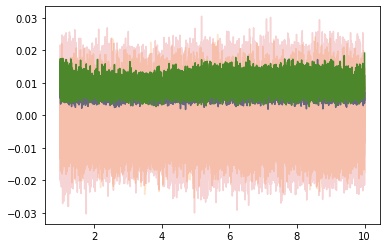

In [326]:
d,t,sr = loadasom('22')
cut_start = 1*sr
b, a = scipy.signal.butter(4, 0.08)
c = d['pump']['a'][0][1]

e = scipy.signal.filtfilt(b,a,get_raw_envelope(c),padlen=150)[cut_start:]
print(scipy.integrate.simps(e))
print(np.mean(e))
plt.plot(t[cut_start:],e)
plt.plot(t[cut_start:],c[cut_start:], alpha=0.2)
c = d['pump']['n'][0][1]

e = scipy.signal.filtfilt(b,a,get_raw_envelope(c),padlen=150)[cut_start:]
print(scipy.integrate.simps(e))
print(np.mean(e))

plt.plot(t[cut_start:],e)
plt.plot(t[cut_start:],c[cut_start:], alpha=0.2)

## slope

# event counter

# multi channel covaraince based 

# CWT based 

In [ ]:
https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.signal.find_peaks_cwt.html